In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt


In [2]:
train_input, train_target, train_classes, test_input, test_target, test_classes = [x.cuda() for x in prologue.generate_pair_sets(1000)]

In [3]:
class ConvNet(nn.Module):
    '''
    Input size :            2x14x14
    nn.Conv2d(2, 32, k=3) : 32x12x12
    F.max_pool2d(k=2) :     32x6x6
    nn.Conv2d(32, 64, k=3): 64x4x4
    F.max_pool2d(k=2):      64x2x2
    '''
    def __init__(self, nb_digits):
        super().__init__()        
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3)
        self.dropout1 = nn.Dropout2d(p = 0.2) # Removes entire channel randomly, so dropout -> maxpool = maxpool -> dropout
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3)
        self.dropout2 = nn.Dropout2d(p = 0.2) # Removes entire channel randomly, so dropout -> maxpool = maxpool -> dropout
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(128, nb_digits)
        self.fc2 = nn.Linear(2 * nb_digits, 2)
        
    def forward(self, x):
        batch_size, nb_channels, image_rows, image_cols = x.size()
        
        # Reshape the tensor such that along batch dimention we have first image first batch element, second image first batch element,
        # first image second batch element, ...
        x = x.view(nb_channels * batch_size, 1, image_rows, image_cols)
        
        # The treatement for all single images is same
        x = F.relu(self.maxpool1(self.dropout1(self.conv1(x))))
        x = F.relu(self.maxpool2(self.dropout2(self.conv2(x))))
        
        # Reshapes to 2*batch_size, 128
        digits_pred = self.fc1(x.view(2 * batch_size, -1))
        
        x = F.softmax(digits_pred, dim = 1)
        
        # group digit predictions for same batch element in same vector
        # reshpaes to batch_size, 2*nb_digits
        x = x.view(batch_size, -1)
        
        x = self.fc2(x)
        return x, digits_pred

In [4]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size = 100):    
    
    nb_data_errors = 0
    
    for b in range(0, data_input.size(0), mini_batch_size):
        batch_input  = data_input .narrow(0, b, mini_batch_size)
        batch_target = data_target.narrow(0, b, mini_batch_size)
        
        output, _ = model(batch_input)
        
        predicted_classes = torch.argmax(output, 1)
        
        nb_data_errors += (predicted_classes != batch_target).sum()

    return nb_data_errors

In [21]:
def train_model(model, train_input, train_target, train_classes, nb_epochs = 50, mini_batch_size = 100, lr = 1e-3, beta = 0.5):
    criterion_digits     = nn.CrossEntropyLoss()
    criterion_comparison = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    # 3 is number of losses to track: digit, comparison, tot
    loss_train = torch.zeros(nb_epochs, 3, requires_grad = False)
    loss_test  = torch.zeros(nb_epochs, 3, requires_grad = False)
    
    # 2 is number of accuracies to track: digit, comparison
    errors_train = torch.zeros(nb_epochs, 2, requires_grad = False)
    errors_test  = torch.zeros(nb_epochs, 2, requires_grad = False)
    
    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            batch_input   = train_input  .narrow(0, b, mini_batch_size)
            batch_target  = train_target .narrow(0, b, mini_batch_size)
            batch_classes = train_classes.narrow(0, b, mini_batch_size).view(-1)
            
            output_comparison, digits_pred = model(batch_input)
                        
            loss_digits     = criterion_digits(digits_pred, batch_classes)
            loss_comparison = criterion_comparison(output_comparison, batch_target)
            loss_tot        = beta * loss_comparison + (1 - beta) * loss_digits
                        
            optimizer.zero_grad()
            loss_tot .backward()
            optimizer.step()
            
            loss_train[e] += torch.tensor([loss_digits, loss_comparison, loss_tot]) # This normalization factor is probably wrong. Double check
                        
            errors_digits     = (digits_pred.argmax(axis = 1) != batch_classes).sum()
            errors_comparison = (output_comparison.argmax(axis = 1) != batch_target).sum()

            errors_train[e] += torch.tensor([errors_digits, errors_comparison])
            
            
        with torch.no_grad():
            model.eval()
            for b in range(0, test_input.size(0), mini_batch_size):
                batch_input   = test_input  .narrow(0, b, mini_batch_size)
                batch_target  = test_target .narrow(0, b, mini_batch_size)
                batch_classes = test_classes.narrow(0, b, mini_batch_size).view(-1)

                output_comparison, digits_pred = model(batch_input)

                loss_digits     = criterion_digits(digits_pred, batch_classes)
                loss_comparison = criterion_comparison(output_comparison, batch_target)
                loss_tot        = beta * loss_digits + (1 - beta) * loss_comparison

                loss_test[e] += torch.tensor([loss_digits, loss_comparison, loss_tot])
                
                errors_digits     = (digits_pred.argmax(axis = 1) != batch_classes).sum()
                errors_comparison = (output_comparison.argmax(axis = 1) != batch_target).sum()

                errors_test[e] += torch.tensor([errors_digits, errors_comparison])

            model.train()

        
    fig, (ax_loss, ax_errors) = plt.subplots(1, 2, figsize = (15, 4))
    ax_loss.plot(loss_train.cpu().detach())
    ax_loss.plot(loss_test .cpu().detach())
    ax_loss.legend(['loss train digit', 'loss train comparison', 'loss train tot', 'loss test digit', 'loss test comparison', 'loss test tot'])
    
    ax_errors.plot(errors_train.cpu().detach())
    ax_errors.plot(errors_test .cpu().detach())
    ax_errors.legend(['errors train digit', 'errors train comparison', 'errors train tot', 'errors test digit', 'errors test comparison', 'errors test tot'])
    
    plt.show()
    
    return errors_train[-1, 1], errors_test[-1, 1]

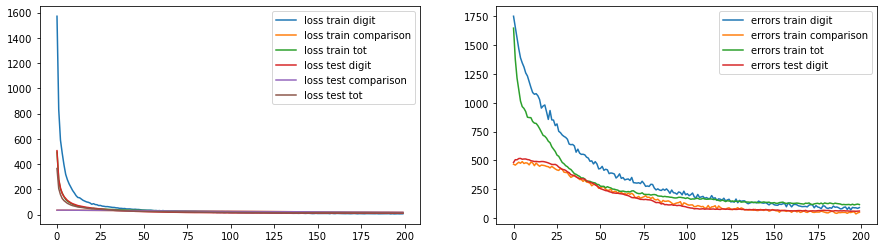

train_error 5.40% test_error 8.20%


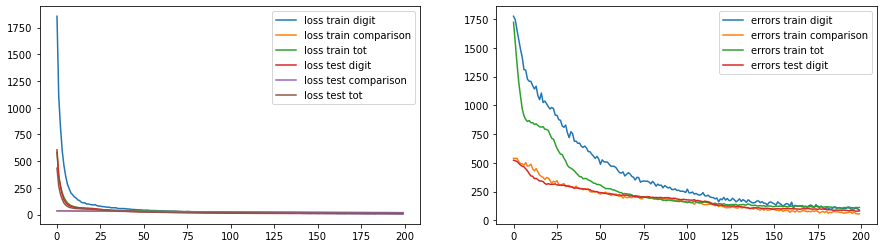

train_error 7.10% test_error 10.30%


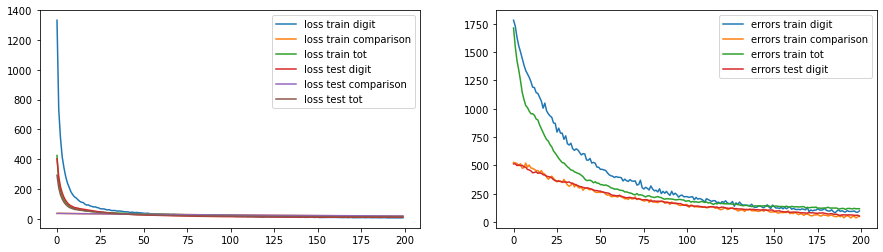

train_error 4.90% test_error 9.10%


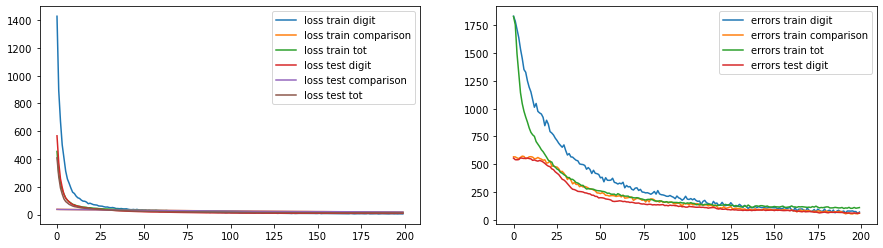

train_error 5.30% test_error 7.80%


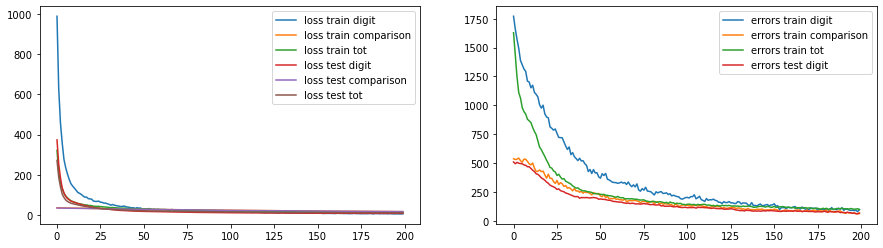

train_error 6.70% test_error 7.50%


In [22]:
train_E=[]
test_E=[]

for k in range(5):
    model = ConvNet(nb_digits = 10).cuda()
    train_model(model, train_input, train_target, train_classes, beta = 0.7, lr = 1e-4, nb_epochs = 200, mini_batch_size = 20)
    train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
    test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)
    
    print('train_error {:.02f}% test_error {:.02f}%'.format(train_E[-1], test_E[-1]))